In [1]:
!git clone https://github.com/karpathy/nanoGPT

Cloning into 'nanoGPT'...
remote: Enumerating objects: 686, done.
remote: Total 686 (delta 0), reused 0 (delta 0), pack-reused 686 (from 1)
Receiving objects: 100% (686/686), 954.03 KiB | 1.38 MiB/s, done.
Resolving deltas: 100% (387/387), done.


In [5]:
%pwd

'/content'

In [6]:
%cd /content/nanoGPT/

/content/nanoGPT


In [8]:
# Part 2: Train the Shakespeare Character-level Model

!python data/shakespeare_char/prepare.py

!python train.py config/train_shakespeare_char.py

length of dataset in characters: 1,115,394
all the unique characters: 
 !$&',-.3:;?ABCDEFGHIJKLMNOPQRSTUVWXYZabcdefghijklmnopqrstuvwxyz
vocab size: 65
train has 1,003,854 tokens
val has 111,540 tokens
Overriding config with config/train_shakespeare_char.py:
# train a miniature character-level shakespeare model
# good for debugging and playing on macbooks and such

out_dir = 'out-shakespeare-char'
eval_interval = 250 # keep frequent because we'll overfit
eval_iters = 200
log_interval = 10 # don't print too too often

# we expect to overfit on this small dataset, so only save when val improves
always_save_checkpoint = False

wandb_log = False # override via command line if you like
wandb_project = 'shakespeare-char'
wandb_run_name = 'mini-gpt'

dataset = 'shakespeare_char'
gradient_accumulation_steps = 1
batch_size = 64
block_size = 256 # context of up to 256 previous characters

# baby GPT model :)
n_layer = 6
n_head = 6
n_embd = 384
dropout = 0.2

learning_rate = 1e-3 # with baby netwo

In [9]:
!pip install tiktoken

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.2/1.2 MB 54.6 MB/s eta 0:00:00


In [10]:
# generate samples from the trained model
!python sample.py --out_dir=out-shakespeare-char --device=cuda

Overriding: out_dir = out-shakespeare-char
Overriding: device = cuda
number of parameters: 10.65M
Loading meta from data/shakespeare_char/meta.pkl...


KING RICHARD II:
Sweet Lord Hastings, was the army that world?

Messenger:
Nurse, I will determine, away!

KING RICHARD III:

YORK:
My friend Scroop, my lord.

RICHARD:
I hear them in the soul.

WARWICK:
Ay, and well in the likeness of his soul:
Marshal, the world's not of this death:
I would tell thou the hour Clifford, and therefore now;
But poor of hours are admitted to speak in his shroud.
Talk of when here? thou shalt have no foot in his sake,
And he makes the king and his his charm for hi
---------------

Men your knees,
I would not be made a changed-foolman.

Second Servant:
Why, how now, uncled, whom comforted should so,
I may as he loved him shall be better than my soul
To our plaining of the needless creditate.

Second Servant:
Here's a pointed so man of the beauty as his business soul.

Clown:
For here is here this and head i


Training model with 2 layers and 4 heads
Running command: python train.py config/train_shakespeare_char_2layer_4head.py
/content/nanoGPT/train.py:196: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
scaler = torch.cuda.amp.GradScaler(enabled=(dtype == 'float16'))
W0503 17:01:13.103000 10725 torch/_inductor/utils.py:1137] [0/0] Not enough SMs to use max_autotune_gemm mode
Overriding config with config/train_shakespeare_char_2layer_4head.py:
# train a miniature character-level shakespeare model
# good for debugging and playing on macbooks and such

out_dir = 'out-shakespeare-char'
eval_interval = 1000 # keep frequent because we'll overfit
eval_iters = 200
log_interval = 10 # don't print too too often

# we expect to overfit on this small dataset, so only save when val improves
always_save_checkpoint = False

wandb_log = False # override via command line if you like
wandb_project = 'shakespeare-char'
wandb_run

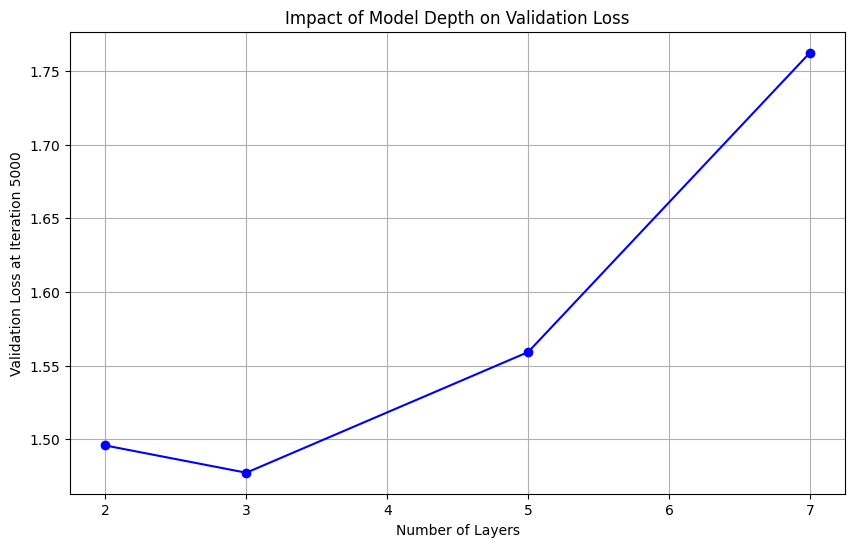


Best configuration: 3 layers with 4 heads, validation loss: 1.4773


In [11]:
# Part 3: Model Architecture Exploration

import os
import re
import matplotlib.pyplot as plt
import numpy as np
import subprocess
import io

# create figures directory
!mkdir -p figures

# modify the configuration file
def modify_config(n_layer, n_head):
    with open('config/train_shakespeare_char.py', 'r') as f:
        config = f.read()

    # modify key parameters
    config = re.sub(r'n_layer = \d+', f'n_layer = {n_layer}', config)
    config = re.sub(r'n_head = \d+', f'n_head = {n_head}', config)
    # make sure we're using a reasonable number of iterations
    config = re.sub(r'max_iters = \d+', 'max_iters = 6000', config)
    config = re.sub(r'eval_interval = \d+', 'eval_interval = 1000', config)

    # create a new configuration file
    new_config_path = f'config/train_shakespeare_char_{n_layer}layer_{n_head}head.py'
    with open(new_config_path, 'w') as f:
        f.write(config)

    return new_config_path

# extract loss values from training log
def extract_loss_from_log(log_text, target_iter=5000):
    # Find the eval step closest to the target iteration
    iter_pattern = r"step (\d+): train loss ([\d.]+), val loss ([\d.]+)"
    matches = re.findall(iter_pattern, log_text)

    if not matches:
        return None, None

    # Find the evaluation step closest to target_iter
    closest_match = min(matches, key=lambda x: abs(int(x[0]) - target_iter))
    iter_num, train_loss, val_loss = closest_match

    return float(train_loss), float(val_loss)

# fixed number of heads = 4
n_heads = 4
n_layers_list = [2, 3, 5, 7]
train_losses = []
val_losses = []

for n_layer in n_layers_list:
    print(f"\nTraining model with {n_layer} layers and {n_heads} heads")

    config_path = modify_config(n_layer, n_heads)

    command = f"python train.py {config_path}"
    print(f"Running command: {command}")

    # run the command and capture output
    process = subprocess.Popen(command, shell=True, stdout=subprocess.PIPE, stderr=subprocess.STDOUT, text=True)
    log_output = ""

    while True:
        output = process.stdout.readline()
        if output == '' and process.poll() is not None:
            break
        if output:
            print(output.strip())
            log_output += output

    process.communicate()

    # extract the loss values from the log
    train_loss, val_loss = extract_loss_from_log(log_output, target_iter=5000)

    if train_loss is not None and val_loss is not None:
        print(f"Extracted losses: train={train_loss}, val={val_loss}")
        train_losses.append(train_loss)
        val_losses.append(val_loss)


# filter out None values for plotting
valid_points = [(layer, loss) for layer, loss in zip(n_layers_list, val_losses) if loss is not None]
if valid_points:
    valid_layers, valid_val_losses = zip(*valid_points)

    # Plot the validation loss versus number of layers
    plt.figure(figsize=(10, 6))
    plt.plot(valid_layers, valid_val_losses, marker='o', linestyle='-', color='blue')
    plt.xlabel('Number of Layers')
    plt.ylabel('Validation Loss at Iteration 5000')
    plt.title('Impact of Model Depth on Validation Loss')
    plt.grid(True)
    plt.savefig('figures/layers_vs_loss.png')
    plt.show()

    # determine the best configuration
    best_idx = np.argmin(valid_val_losses)
    best_n_layer = valid_layers[best_idx]
    best_val_loss = valid_val_losses[best_idx]
    print(f"\nBest configuration: {best_n_layer} layers with {n_heads} heads, validation loss: {best_val_loss}")

In [12]:
# Part 4: Training BabyGPT for Code Generation

!mkdir -p data/code_generation

# copy the prepare.py file from the shakespeare dataset
!cp data/shakespeare_char/prepare.py data/code_generation/

# download Python code from GitHub repositories for the dataset
import requests

def download_github_file(repo, path, branch="main"):
    url = f"https://raw.githubusercontent.com/{repo}/{branch}/{path}"
    response = requests.get(url)
    if response.status_code == 200:
        return response.text
    else:
        print(f"Failed to download {url}, status code: {response.status_code}")
        return ""

# repositories and files to download - including more to reach 100k tokens
repos_and_files = [
    # PyTorch examples
    ("pytorch/pytorch", "torch/nn/modules/activation.py", "master"),
    ("pytorch/pytorch", "torch/nn/modules/linear.py", "master"),
    ("pytorch/pytorch", "torch/nn/modules/loss.py", "master"),
]

# combine into a dataset
code_collection = ""

for repo, path, branch in repos_and_files:
    print(f"Downloading {path} from {repo}...")
    code = download_github_file(repo, path, branch)
    if code:
        code_collection += f"\n# Source: {repo}/{path}\n\n{code}\n\n"

# write to input.txt
with open('data/code_generation/input.txt', 'w') as f:
    f.write(code_collection)

print(f"\nTotal characters in code dataset: {len(code_collection)}")

# prepare the code dataset
!python data/code_generation/prepare.py

# create a new configuration file for code generation
with open('config/train_shakespeare_char.py', 'r') as f:
    shakespeare_config = f.read()

# Modify the configuration for code generation
code_gen_config = shakespeare_config.replace(
    "dataset = 'shakespeare_char'",
    "dataset = 'code_generation'"
)
code_gen_config = code_gen_config.replace(
    "out_dir = 'out-shakespeare-char'",
    "out_dir = 'out-code-generation'"
)
code_gen_config = code_gen_config.replace(
    "max_iters = \d+",
    "max_iters = 6000"
)
code_gen_config = code_gen_config.replace(
    "eval_interval = \d+",
    "eval_interval = 1000"
)

with open('config/train_code_generation.py', 'w') as f:
    f.write(code_gen_config)

# train the model on the code dataset
!python train.py config/train_code_generation.py

# generate samples from the trained model
!python sample.py --out_dir=out-code-generation --max_new_tokens=500

# get token count from meta.pkl
import pickle
token_count = "Unknown"
try:
    with open('data/code_generation/meta.pkl', 'rb') as f:
        meta = pickle.load(f)
        token_count = len(np.memmap('data/code_generation/train.bin', dtype=np.uint16, mode='r'))
        vocab_size = meta.get('vocab_size', 'Unknown')
        print(f"Token count: {token_count}, Vocabulary size: {vocab_size}")
except Exception as e:
    print(f"Error getting token count: {e}")


Total characters in code dataset: 163121
length of dataset in characters: 163,121
all the unique characters: 
 !"#%&'()*+,-./0123456789:;<=>?@ABCDEFGHIKLMNOPQRSTUVWXY[\]^_`abcdefghijklmnopqrstuvwxyz{|}~
vocab size: 93
train has 146,808 tokens
val has 16,313 tokens
Overriding config with config/train_code_generation.py:
# train a miniature character-level shakespeare model
# good for debugging and playing on macbooks and such

out_dir = 'out-code-generation'
eval_interval = 250 # keep frequent because we'll overfit
eval_iters = 200
log_interval = 10 # don't print too too often

# we expect to overfit on this small dataset, so only save when val improves
always_save_checkpoint = False

wandb_log = False # override via command line if you like
wandb_project = 'shakespeare-char'
wandb_run_name = 'mini-gpt'

dataset = 'code_generation'
gradient_accumulation_steps = 1
batch_size = 64
block_size = 256 # context of up to 256 previous characters

# baby GPT model :)
n_layer = 6
n_head = 6
n_em